In [1]:
# import some library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import lightgbm as lgb
import itertools
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# read data
df = pd.read_csv('../data/feature_selection_positive.csv', index_col=0)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [ ]:
# # Use large max_bin (may be slower)
# # Use small learning_rate with large num_iterations
# # Use large num_leaves (may cause over-fitting)
# # Try dart

# # initial parameters on LGBMClassifier
# # boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, 
# # subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, 
# # min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
# # colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, 
# # silent=True, importance_type='split', **kwargs

params = {
    'num_leaves': [31, 100, 150],
    'max_depth': [100, 200, -1],
    'min_child_samples': [20, 40, 60],
    'boosting': ['gbdt','dart']
}

gbm = lgb.LGBMClassifier(
    objective='multiclass',
    device = 'gpu',
    n_jobs=-1 
)

clf = GridSearchCV(
    gbm,
    params,
#     verbose=0,
    cv=3,
    n_jobs=-1
)

clf.fit(X_train, y_train)
clf.scorere(X_test, y_test)
# pickle.dump(gbm, open('../model/LGBM_best_params_fs.sav', 'wb'))

In [ ]:
# gbm = lgb.LGBMClassifier(
#     objective='multiclass',
#     device='gpu',
#     max_bin=255,
#     metric='multi_logloss',
#     learning_rate=0.1,
#     num_leaves=1000,
#     boosting='gbdt',
#     num_iterations=10000,
#     num_class=4,
# )

# gbm.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_test, y_test)],
#     early_stopping_rounds=50,
# )

# print(gbm.score(X_test, y_test))

In [5]:
# accuracy
# pickle.dump(gbm, open('../model/LGBM_best_params.sav', 'wb'))

In [8]:
# load mdel
loaded_model = pickle.load(open('../model/LGBM_best_params_fs.sav', 'rb'))

In [10]:
loaded_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [11]:
loaded_model.scorere(X_test, y_test)

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8363095238095238

In [7]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


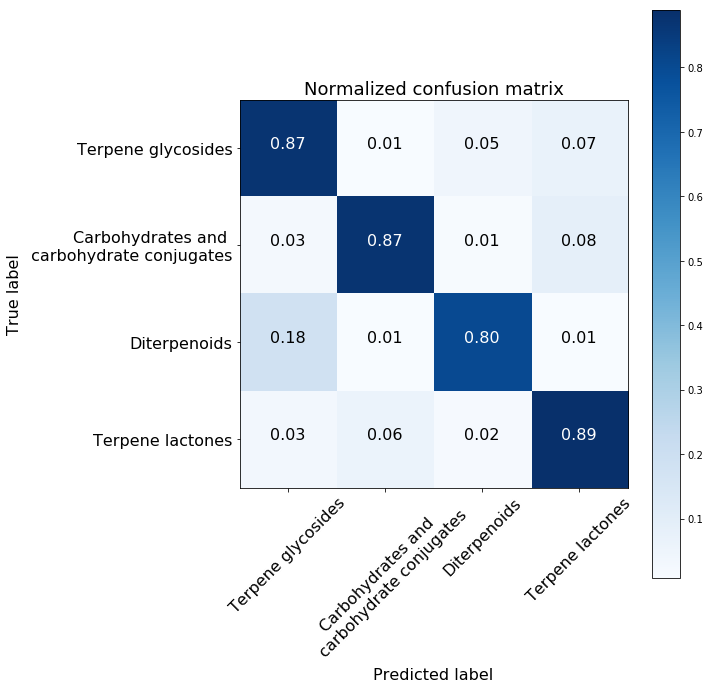

In [8]:
# set name list
class_names = list(df.Subclass.value_counts().index)
class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbm.predict(X_test))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [10]:
# load mdel
loaded_model

# load mdel
x = pickle.load(open('../model/XGB_best_params.sav', 'rb'))

In [13]:
round((sum(np.argmax((loaded_model.predict_proba(X_test)+x.predict_proba(X_test)) , axis=1) == y_test)/len(y_test))*100, 2)

84.52